# Model Project: The Agents Labour Supply Decision


In present project we seek to model the supply of labour by studying a two-good static problem, where agents value leisure and consumption. As an extension for the base model we impose a progressive tax system, which creates kinks in the budget constraint. We then show, how this may create bunching around tax bracket cut-offs.

The basic problem of the agents is:


$$\begin{aligned}  \max_{c,l}\ \ &u(c,l) \quad s.t. \ \ R_0 = wl + c  \quad c,l\geq0\\
 &\dfrac{\partial u}{\partial a}= u_a>0 \quad  \wedge \quad \dfrac{\partial^2 u}{\partial a^2}=u_{aa}<0,  \qquad a=c,l \\
 &R_0=W_0 + A_0 = w T + A_0
 \end{aligned} $$
 

Where $R_0$ is the income potential of the agent, $c$ the consumption which is a numeraire, $l$ is the amount of leisure consumed with the associated oppurtunity cost being the wage rate, $w$. We assume marginal utility of consumption and leisure are positive but decreasing. Further we for now assume the income potential is the sum of wage earning potential, $W_0$, which is the renumeration for working the entirety of the time endowment ($T$ units), plus non-labour income, $A_0$.
<br> The problem is framed such that the agent at default suplies all his time as labour, giving her/him an income of $R_0$. The agent now has to decide how much leisure she/he will 'buy back', considering the consumption that is implied.

The Langrangian for the problem is:
$$ \mathcal{L}(c,l; \lambda)= u(c,l)\ + \ \lambda( R_0 - wl - c) $$ 
For which the first order conditions with regards to $c$ and $l$ implies an optimum at $\dfrac{u_l}{u_c}=w$ as the constraint is binding.

##  1. Numerical optimization

We will solve this problem using a numerical optimizer, which will allow for easy handling of extensions to this basic model. 

Dependencies:

In [3]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy.optimize import Bounds
import scipy.integrate as integrate
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import functions as fun

First we code up two utility functions, a CES and a Cobb-Douglas, but any utility function that observes the above restrictions can be implemented.

In [4]:
# Cobb-Douglas:
def  cobbdouglas(x, par):
    """ Cobb douglas utility function for 2 goods.
    
    INPUT:
    
    Parameters
    par (alpha) : relative preference for consumption to leisure, 0<alpha<1
    
    Consumption bundle
    x           : Consumption tuple
      x[0]      : consumption
      x[1]      : leisure

    OUTPUT
    u           : utility (negative)"""
    
    c=x[0]
    l=x[1]
    alpha=par
    
    u= (c**alpha)*l**(1-alpha)
    return -u

# CES utility function:
def CES(x, par):
    """ CES utility function for 2 goods.
    INPUT:
    
    parameters
    par (2-tuple):
        par[0]   : a
        par[1]   : r
             r   : 1/(1-r) is the elasticity of substitution, r<=1.
             a   : relative preference for consumption (a=1 if a unit of consumption gives the same utility as a unit lesiure),
                    0<=a<=1.
    
    consumption bundle
    x (2-tuple)  :
          x[0]   : consumption of goods (c)
          x[1]   : leisure (l)

    OUTPUT:
            u    : utility (neg) """
    
    a=par[0]
    r=par[1]
    c=x[0]
    l=x[1]
    
    u=(a*c**r + (1-a)*l**r)**(1/r)
    return -u

We now have to define the constraints. Three moving parts are specified for the budget constraint (BC):<br>
1) Wage function: returning the after tax wagerate for for a given level of leisure consumption.<br>
2) Leisure expenditure function: returns the expenditure incurred from buying 'l' units of leisure. <br>
3) The budget function: calculates the slack in budget given choices of leisure and consumption (the actual constraint). <br>

In [5]:
# 1) Wage function: returning the after tax wagerate for for a given level of leisure consumption (the more leisure the lower taxrate = higher wagerate).<br>
def wage_notax(l):
    """ Marg. wage function with no taxation is constant:
        
        PARAMETERS:
        w: wage rate
        ARGS:
        l: leisure 
        
        OUTPUT:
        The marginal after tax wage rate
    """
    return w
#2) Leisure expenditure function:
def leiexp(l,wage):
    """ Calculates the expenditure from buying l units of leisure given a wage function as the definite integral
    from 0 to l of the wage function.
    ARGS:
    l: leisure consumed (int)
    Wage: Marginal wage-function (incoperating tax system) (function)
    
    OUTPUT:
    leiexp: expenditure on leisure (int)
    """
    return sp.integrate.quad(wage,0,l)[0]

#3) Budget constraint
def budget(x, wage, maxlabinc, leiexp):
    """The budget functin calculates the slack for consumption plan:
    ARGS
    x (2-tuple)
         x[0]: consumption of good
         x[1]: consumption of leisure
    wage(l)  : marg. wage/price of leisure (function)
    maxlabinc: Labour income from working T units of time (int)
    leiexp   : leisure expenditure (function)
    
    OUTPUT:
    slack: 'Leftover' given consumption plan x.
    """
    c=x[0]
    l=x[1]
    R0= maxlabinc + A
    slack= R0 - leiexp(l, wage) - c
    return  slack

def budget_func(wage,maxlabinc,leiexp):
    """ Produces the budget constraint to input in maximizer.  It is a equality contraint -> slack shall be zero in optimum
    as marg. utility of both goods is stricty positive.
    
    ARGS:
    Wage: marg. wage function
    maxlabinc: integral of wage fucntion from 0 to T
    leiexp   : leisure expenditure (function)
    
    OUTPUT:
    Budget Contraint: Dict. specifying the constraint to be used in scipy.optimize.minimize
    """
    return {'type':'eq', 'fun':budget, 'args': [wage, maxlabinc,leiexp]} 

Note: 1) That we define the wage as a function this allows us to extend the model, 2) Expenditure on leisure is calculated as the definite integral of the wage function from 0 to l, this allows for altering the wage function
3) we have yet to define the bounds on consumption/leisure, as these depend on T, we will define them within when parameters are chosen.



## 2. Cobb Douglas utility with lump sum taxation
For a Cobb-Douglas utility functions, $u(c,l)= c^\alpha l^{1-\alpha}$, the solution Marshallian demand functions are:
$$c^*= w l \left(\dfrac{\alpha}{1-\alpha}\right)=R_0 \alpha \qquad l^*=\dfrac{R_0 (1-\alpha)}{w}$$
These can be obtained by isolating factor demand for one good from the optimum condition and inserting this into the budget constraint.
However to initially test our program, we will compare the analytical solution for a particular set of parameters to the optimizer:

In [6]:
# Budget related parameters
T=10 # 10 units of time endowed
w=10 # flat hourly wage of 10
A=0 # 0 income from non labour sources
maxlabinc_notax=leiexp(T,wage_notax) #Calculates max labour inc given flat
# Optimizer setup:
bounds= Bounds((0,0), (np.inf, T))

The general parameters of both this model and the extension (progressive taxation) is $w=10$, $A_0=0$, and $T=10$.

#### 2.1 Testing the optimizer 
The numerical optmization is performed by the 'SLSQP' algorithm for constrained optimization included in sci.py and is compared to the analytical solution for $\alpha=0.5$:

In [7]:
guess_flat=(70,5) # provide the optmizer with a starting point
alpha1=0.5
result = optimize.minimize(cobbdouglas,guess_flat,args=alpha1,
                             method='SLSQP',
                             constraints=[budget_func(wage_notax,maxlabinc_notax,leiexp)],
                             options={'disp':True}, bounds=bounds)
 
c_star=(maxlabinc_notax+ A)*alpha1 # analytical optimal consumption of goods
l_star=((maxlabinc_notax+ A)/w)*(1-alpha1) # analytical optimal consumption of leisure
print('\n Numerical optimum found at (consumption, leisure) =', result.x)
print('\n The analytical optimum is found at (consumption,leisure)=',(c_star,l_star) )


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -15.811388300616342
            Iterations: 8
            Function evaluations: 32
            Gradient evaluations: 8

 Numerical optimum found at (consumption, leisure) = [50.00026707  4.99997329]

 The analytical optimum is found at (consumption,leisure)= (50.0, 5.0)


Deviations in the analytical and numerical solutions can be chalked up to numerical precision.

### 2.2 Plotting the solution
Graphically we can illustrate the solution aswell. We use the numerical optimizer to find the best consumption bundle, and then plot the indifference curve by finding bundles that provide equivalent utility to this optimal bundle:


In [8]:
def max_u(util, wage, maxlabinc, leiexp,par):
    """Return utility for optimal consumption bundle.
    INPUT:
    Util: Utility function (CES or cobbdouglas)
    wage: wage function
    maxlabinc: max. wage income if all time is supplied as labour
    leiexp: Expenditure on leisure
    par: parameters for util function
    
    OUTPUT:
    max_U: Utility derived in optimum
    """
    if util=="cobbdouglas":
        # Call optimizer
        temp = optimize.minimize(cobbdouglas, guess_flat,args=par, method='SLSQP',                        
           constraints=[budget_func(wage, maxlabinc, leiexp)], options={'disp':False}, bounds=bounds)
        return -temp.fun
    elif util=="CES":
        temp = optimize.minimize(CES, guess_flat,args=par, method='SLSQP',                        
           constraints=[budget_func(wage, maxlabinc, leiexp)], options={'disp':False}, bounds=bounds)
        return -temp.fun
    else:
        print(f'Utility function not recognized, util can be cobbdouglas or CES')
    
def indif_opt(util,max_u,par):
    """ Function to plot indifference curve for a given utility level and function.
    INPUT:
    util: utility func (either CES or Cobbdouglas at present)
    max_u: utility in optimum (found from maximiation by numerical or analytical means)
    alpha: utility fucntion parameter
    
    OUTPUT:
    c: goods consumption that ensures u_bar utility given l leisure.
    """
    if util=="cobbdouglas":
        c_indif=lambda l: max_u**(1/par)*l**((par-1)/par)
        return [c_indif(x) for x in np.linspace(0.01,10,100)]
    elif util=="CES":
        a=par[0]
        r=par[1]
        c_indif=lambda l: ((max_u-(1-a)*l^r)/a)^(1/r)
        return [c_indif(x) for x in np.linspace(0.01,10,100)]
    else:
        print(f'Undefined utility function provided, util is either CES or cobbdouglas')

We use the above 'indif_opt' to retrieve indifference curve and plot the budget constraint is plotted by a lambda-function calculating the implied goods consumption for a level of leisure and $R_0$ and use the 'max_u' to calculate the utility in optimum for a given parameterization:

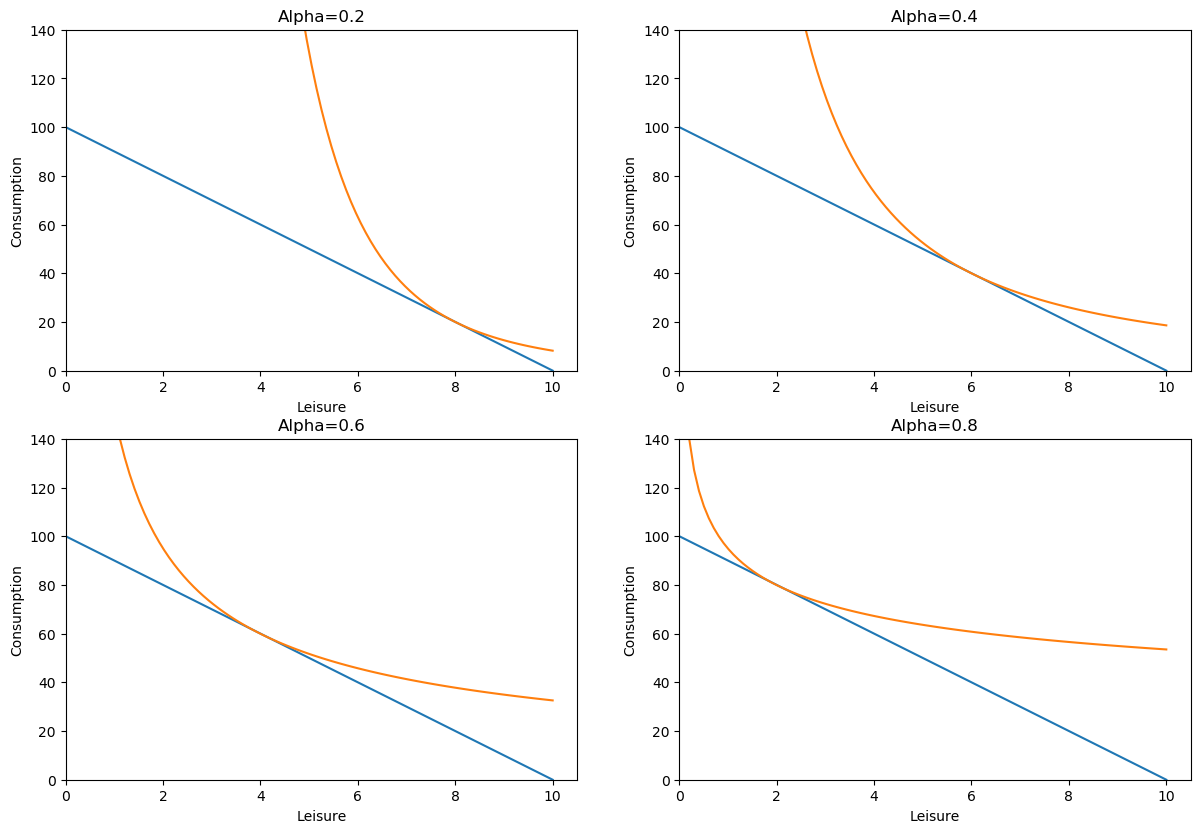

In [16]:
#plotting the lump sum tax case:
fig = plt.figure(dpi=100)

gs=fig.add_gridspec(2,2)
   
for i in range(1,5):
    # ii. figure
    
    ax = fig.add_subplot(2,2,i)
    
    if i==1:
        alpha1=0.2
        text='Alpha=0.2'
    elif i==2:
        alpha1=0.4
        text='Alpha=0.4'
    elif i==3:
        alpha1=0.6
        text='Alpha=0.6'
    else:
        alpha1=0.8
        text='Alpha=0.8'
        
    #Define income potential in the non taxated scenario.
    R_0_notax = maxlabinc_notax + A

#Define function for the base budget line 
    goods_notax = lambda l: R_0_notax -leiexp(l,wage_notax)
    cons_notax = [goods_notax(x) for x in np.linspace(0,10,num=100)]
    leisure1 = np.linspace(0,10,100)

#Plot the budget line with axis names
    ax.plot(leisure1,cons_notax)

#Plotting the indiffence curve 
    ax.plot(leisure1,indif_opt(util="cobbdouglas",max_u=max_u(util="cobbdouglas",wage=wage_notax,maxlabinc=maxlabinc_notax,leiexp=leiexp,par=alpha1),par=alpha1))
    ax.set_xlabel("Leisure")
    ax.set_ylabel("Consumption")
    ax.set_ylim(0,140)
    ax.set_xlim(0,10.5)
    ax.title.set_text(text)
    plt.subplots_adjust(top=2,right=2)


We see from the figures above, that when $\alpha$ is increasing, consumers tend to substitute towards more consumption, meaning that they work more ("Buy less of thier leisure time back"). When $\alpha$ is decreasing, consumers value leisure relatively more than consumption (which you get by working), so they will choose to work less (buy much of their leisure back), and have more leisure. 

## 3. Proportional taxation

Now consider a tax system levying a constant tax rate, $t_cons$, on all income earned. Here the wage function is:

In [17]:
def wage_constax(l):
    """ Marg. wage function with no taxation is constant:
        
        PARAMETERS:
        w: wage rate
        ARGS:
        l: leisure 
        
        OUTPUT:
        The marginal after tax wage rate
    """
    return w*(1-tcons)

## 3. Cobb Douglas with progressive tax system

We institute a tax system that has 3 brackets: no tax, bottom tax and top tax brackets. Due to the way we frame the problem, this amounts to the marginal cost of leisure increasing in the demand for leisure. This is to say, the more leisure an agent consumes the lower his marginal tax is (because earnings are low), thus the marginal price (which is the after tax wage rate) of leisure increases. This can be expressed as:
$$w(l) = \begin{cases} & w \quad &\text{for } l> l_{bottom} \\
                       & w \times (1-t_{bottom}) \quad &\text{for } l_{top} <l < l_{bottom}  \\
                       & w \times (1-t_{top}) \quad &\text{for } l < l_{top}  \end{cases}, \quad l_{bottom}> l_{top} \ \wedge \ t_{bottom}<t_{top}$$

First we code up a wage function, which accounts for changes in marginal taxation:

In [10]:
#1) Wage function 
def wage_prog(l):
    """ Wage function for a progressive tax system with allowing for two specified kinks
        2 kinks (3 tax brackets).
        
        PARAMETERS:
        cut1, cut2: cutoff for tax brackets defined by consumption of
                    leisure.
        w0,w1,w2: wage rates in the respective tax brackets.
        
        ARGS:
        demand typle, x: x[0] cons, x[1] lesiure consumption
        
        OUTPUT:
        w0,w1,w2: the appropriate marginal after tax wage rate
    """
    if l < l_top:
        return w*(1-toptax)
    elif l_top<= l and l < l_bot:
        return w*(1-bottax)
    else:
        return w

In the example for constant wage we defined the leisure expenditure as the definite integral of the wage function, which was approximated numerically (SciPy). However the quadrature approximation we employed does not perform as well on a non-smooth function, like the progressive wage function. Thus we resort to deriving the analytical integral, which we define as the leisure expenditure function:
$$ leisure\_expenditure\_prog = \begin{cases} &(1-t_{top})w \times l \quad &\text{for }l<l_{top}\\
                                              &(1-t_{top})w \times l_{top} + (1-t_{bottom})w \times (l-l_{top})\quad &\text{for } l_{top} <l < l_{bottom}\\
                                                          &(1-t_{top})w \times l_{top} + (1-t_{bottom})w \times (l_{bot}-l_{top}) + w \times (l-l_{bot}) &\text{for } l_{bot}<l
\end{cases}$$

In [11]:
#2) leisure expenditure progressive function (analytical):
def leiexp_prog(l,wage): 
    """ Returns the expenditure associated with buying 'l' units of leisure for the progressive tax system using the analytical 
    integral of the marginal wage function. 
    INPUTS
    l      : amount of leisure consumed
    wage   : marg. wage function  NOT USED when the leisure expenditure is calculated analytically, but included such that 
             the program generalizes easily to other wage functions.
    OUTPUT
    leiexp : expenditure associated with buying leisure on the progressive tax system.
    """
    if l < l_top:
        return w*(1-toptax)*l
    elif l_top<= l and l < l_bot:
        return  w*(1-bottax)*(l-l_top)+w*(1-toptax)*l_top
    else:
        return w*(l-l_bot)+w*(1-bottax)*(l_bot-l_top)+w*(1-toptax)*(l_top)


Now we set parameters for the system, taxes, wage and non-labour inc. We also calculate inputs that are constant across parameterizations of the utility function:

In [12]:
# Set wage function 
w=10
l_top= 1/3*T # Work more than 2/3 of your time and pay top tax
l_bot= 2/3*T # work more than 1/3 of your time and pay bottom tax
toptax= 0.6 # setting top tax
bottax= 0.3 # setting bottom tax
A=0
maxlabinc_prog=leiexp_prog(T,wage_prog) # calculate new max labour income
R_0_prog=maxlabinc_prog + A

# Compute consumption bundle at kink points to safe computational
goods = lambda l: R_0_prog - leiexp_prog(l,wage_prog)  # calculates demand for goods given a level of leisure using left over budget
x_bot= (goods(l_bot), l_bot)   # consumption bundle at bottom tax kink.
x_top= (goods(l_top), l_top) # consumption bundle at top tax kink.


We implement a tax system, where the first 1/3 of the time endowment supplied as labour is not taxed, the next 1/3 of time endowment is taxed in the bottom tax bracket, and additional labour is taxed in the top tax bracket. The marginal tax in the bottom tax bracket is set to 30% and in the top tax bracket to 60%. Keeping in mind, that T=10, this, when framed as buying leisure, implies wage and leisure expenditure functions:

$$w(l) = \begin{cases} & 10 \quad &\text{for } l> T\times \dfrac{2}{3} \\
                       & 10 \times (1-0.3) \quad &\text{for } 10 \times \dfrac{2}{3} >l > 10\times \dfrac{1}{3}  \\
                       & 10 \times (1-0.6) \quad &\text{for } 10\times \dfrac{1}{3}>l  \end{cases}$$
<br>
$$ leisure\_expenditure\_prog = \begin{cases} &(1-0.6)w \times l \quad &\text{for }l<\dfrac{10}{3}\\
                                              &(1-0.6)w \times \dfrac{10}{3} + (1-0.3)w \times \left(l-\dfrac{10}{3}\right)\quad &\text{for } \dfrac{10}{3} <l < \dfrac{20}{3}\\
                                                          &(1-0.3)w \times \dfrac{10}{3} + (1-0.6)w \times \left(\dfrac{10}{3}\right) + w \times \left(l-\dfrac{20}{3}\right) &\text{for } \dfrac{20}{3}<l
\end{cases}$$

In [13]:
# Optimizer:
def solverprog(util, par):
    """ Runs SLSQP optimizer for a parameterization for each piecewise linear part of the budget constraint (3),
    and evaluates the kink points (2) aswell, then compares the utility of these 5 points, and returns the leisure consumption
    associated with the highest utility bundle.
    INPUT:
    Util: Utility function of agents.
    par: Parameters of the utility function (tuple if multipile); For cobddouglas an args=alpha (bt. 0 and 1),
    For CES a 2-tuple, where par[0]=a  and par[1]=r, 0<=a<=1 and r <=1.
    OUTPUT
    c^*: optimal leisure consumption (float)
    """
    # Optimize behaviour in no tax bracket (l_bot < l < T):
    guess_no= (goods(1/2*(T-l_bot)), 1/2*(T-l_bot))
    best_notax= optimize.minimize(util,guess_no,args=par,method='SLSQP', constraints=[budget_func(wage_prog,maxlabinc_prog,leiexp_prog)],
                                options={'disp':False}, bounds=Bounds((0,l_bot), (np.inf, T)))
    # Optimize behaviour in low tax bracket ( l_top < l <l_bot):
    guess_low= (goods(1/2*(l_bot-l_top)), 1/2*(l_bot-l_top))
    best_lowtax = optimize.minimize(util,guess_low,args=par, method='SLSQP', constraints=[budget_func(wage_prog,maxlabinc_prog,leiexp_prog)],
                                options={'disp':False}, bounds=Bounds((0,l_top), (np.inf, l_bot)))
    #Optimize behaviour in top tax bracket ( 0 < l < l_top):
    guess_high=(goods(1/2*(l_top)), 1/2*l_top)
    best_hightax = optimize.minimize(util,guess_high,args=par, method='SLSQP', constraints=[budget_func(wage_prog,maxlabinc_prog,leiexp_prog)],
                                options={'disp':False}, bounds=Bounds((0,0), (np.inf, l_top)))
    #Evaluate utility at kink point between no tax and low tax (util(l=l_bot, c=R_0-leiexp(l_bot,wage)):
    Kink_bot = util(x_bot,par) 
    kink_top= util(x_top,par)
    
    # Evaluate candidates and choose optimal bundle
    candidates=np.array([[best_notax.fun, best_notax.x[0], best_notax.x[1]], [best_lowtax.fun, best_lowtax.x[0], best_lowtax.x[1]], [best_hightax.fun,best_hightax.x[0],best_hightax.x[1]], 
                         [Kink_bot, x_bot[0],x_bot[1]], [kink_top, x_top[0],x_top[1]]]) # Create array with all candidates where first element is utility
                                                                                      # 2nd is the consumption bundle as a tuple.
    best_cand=np.argmin(candidates,axis=0) # exstract row number for best bundle.
    return candidates[best_cand[0],2] # returns only optimal leisure choice.


### 3.2Plot the solution

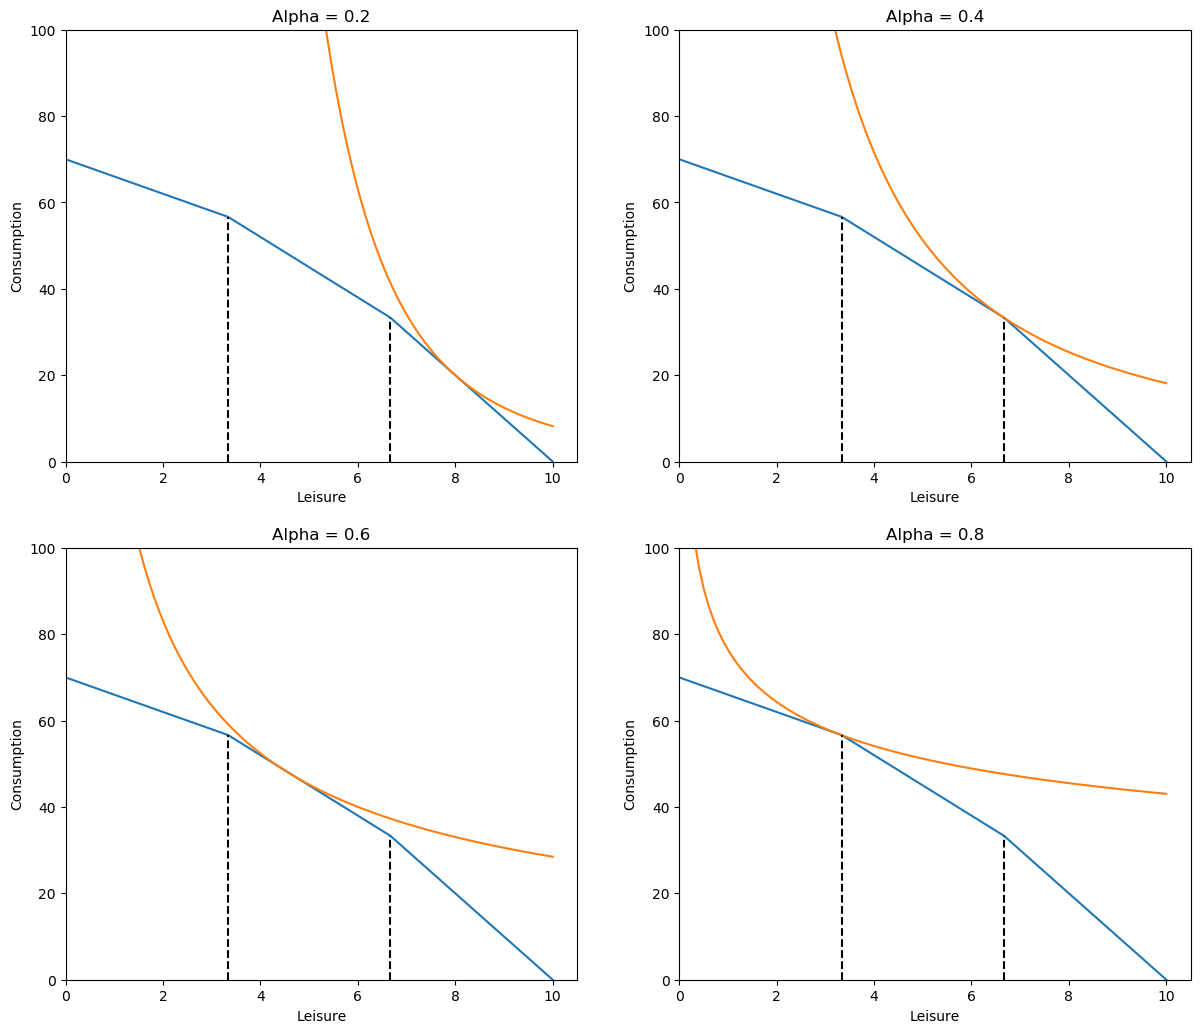

In [15]:
#PLotting with tax brackets

fig = plt.figure(dpi=100)

gs=fig.add_gridspec(2,2)
   
for i in range(1,5):
    # ii. figure
    
    ax = fig.add_subplot(2,2,i)
    
    if i==1:
        alpha1=0.2
        text = "Alpha = 0.2"
    elif i==2:
        alpha1=0.4
        text = "Alpha = 0.4"
    elif i==3:
        alpha1=0.6
        text = "Alpha = 0.6"
    else:
        alpha1=0.8
        text = "Alpha = 0.8"
        
    #Define income potential in the base scenario.
    R_0_prog = maxlabinc_prog + A

#Define function for the base budget line 
    goods_kink = lambda l: R_0_prog -leiexp_prog(l,wage_prog)
    cons_kink = [goods_kink(x) for x in np.linspace(0,10,num=100)]
    leisure1 = np.linspace(0,10,100)

#Plot the budget line with axis names
    ax.plot(leisure1,cons_kink)

#Plotting the indiffence curve 
    
    ax.plot(leisure1,indif_opt("cobbdouglas",max_u("cobbdouglas",wage_prog,maxlabinc_prog,leiexp_prog,alpha1),alpha1))
    ax.set_xlabel("Leisure")
    ax.set_ylabel("Consumption")
    ax.set_ylim(0,100)
    ax.set_xlim(0,10.5)
    ax.title.set_text(text)
    
    plt.plot((l_bot,l_bot),(0,goods(l_bot)),'k--')
    plt.plot((l_top,l_top),(0,goods(l_top)), 'k--')
    
    plt.subplots_adjust(top=2.5,right=2)


In the figures above, the dashed lines (from left: D1, D2) represents the kinks in the budget line, for the different tax brackets. Going from left to right, a consumer with leisure to the left of the first dashed line (D1), will be in the highest tax bracket. Leisure between D1 and D2 will be in the low tax bracket, and consumers to the right of D2 will not be taxed. 
Again, different values of $\alpha$ will make the consumer more inclined to work (in order to consume) or to enjoy leisure (and consume less).


### 3.3 Simulation of bunching
A consequence of a progressive tax system is, agents will bunch below the tax cutoffs (a behavioural effect of taxation). For the Cobb Douglas utility function, we have shown analytically that $1-\alpha$ amounts to the budget share spent on leisure given no taxation (or lump-sum taxation). However given progressive taxation agents, whose $\alpha$ would dictate leisure consumption slightly below a tax cutoff, will experience a rise in the marginal price of leisure, which may make it preferable to choose slightly more leisure and avoid paying the higher tax rate. Only for agents with sufficiently high $\alpha$ will it be optimal to enter next tax bracket. <br>
We can illustrate this rather than proving it analytically by simulating agents with differing draws of $\alpha$. Here we choose $\alpha_i \sim$ uniform$[0.01,0.99]$, and use numerical optmization to find their optimal consumption of leisure and goods, for which we then plot their distribution in choice of leisure consumption. Note Alpha is defined between 0 and 1 for Cobb Douglas, however for robustness in numerical optimization, we elect to sample only between 0.01 and 0.99.

In [25]:
# Draw 'agents' -> characterized by their parameter estimates
np.random.seed(2019); # set the seed
n = 10000; # number of agents simulated
alpha = np.random.uniform(0.01,0.99,size=n)
results =[solverprog(cobbdouglas,par=x) for x in alpha]  # generates list of optimal leisure consumption for all agents given
                                                        # progressive taxation.

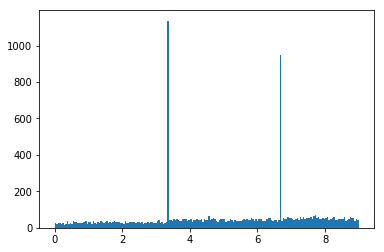

In [26]:
Dens_prog=plt.hist(results, bins=200) ## plots the optimal leisure consumption choices given progressive taxation.

We notice bunching around the tax cutoffs as expected, signified by the excess mass of agents choosing leisure consumption at the cut offs.
Compare these choices to the same agents under a untaxed system with zero non-labour income ($A_0=0$):

In [27]:
def solverdif(util, wage, maxlabinc, leiexp,par):
    """Return utility for optimal consumption bundle given a budget constraint that is continously  differentiable (class C^1).
    INPUT:
    Util: Utility function
    wage: wage function
    maxlabinc: max. wage income if all time is supplied as labour
    leiexp: Expenditure on leisure
    alpha: parameters for util function
    
    OUTPUT:
    max_U: Utility derived in optimum
    """
    # Call optimizer
    temp = optimize.minimize(util, guess_flat,args=par, method='SLSQP',                        
           constraints=[budget_func(wage, maxlabinc, leiexp)], options={'disp':False}, bounds=bounds)
    return temp.x[1]

results =[solverdif(cobbdouglas,wage_notax,maxlabinc_notax,leiexp,x) for x in alpha]  # generates list of optimal leisure consumption for all agents.

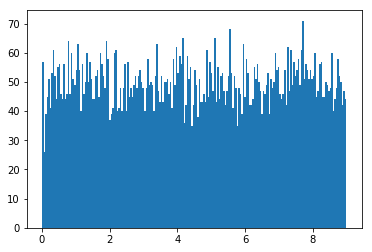

In [29]:
Dens_notax=plt.hist(results, bins=200) ## plots the optimal leisure consumption choices given no taxation.

Here we see one spike, where leisure consumption constitutes all spending, which is unaccounted for in the parameterization (if a=0, we would expect no spike).

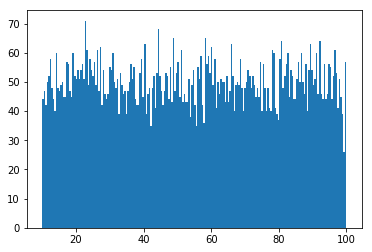

In [30]:
def _goods(l):
    """Converts list of optimal leisure choices to optimal consumption choices
    
    input:
    leisure: list of optimal leisure choices
    
    output:
    goods: list of optimal consumption choices
    """
    temp=lambda l: R_0_notax - leiexp(l,wage_notax) 
    _goods= [temp(x) for x in l]
    return _goods
    
_goods=_goods(results)

Dens_notax=plt.hist(_goods, bins=200)


### Conclussion 